# Import libraries

In [1]:
%matplotlib inline
from PIL import Image
from os import listdir
from skimage import data, img_as_float
from skimage import exposure
from skimage.filters import gaussian
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from sklearn.metrics import classification_report, confusion_matrix
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils, datasets
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import skimage.io as io
import torch
import torch.nn as nn
import torch.nn.functional
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import warnings
warnings.filterwarnings('ignore')

# Reload Data

In [2]:
CsvPath='data/data.csv'
df = pd.read_csv(CsvPath)
train=df[df['Dataset_Type']=="train"]
test=df[df['Dataset_Type']=="test"]

# Histogram Equalization 

Source code : https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

In [3]:
#source code : https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html
matplotlib.rcParams['font.size'] = 8

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


def equalization(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

    # Equalization
    img_eq = exposure.equalize_hist(img)

    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

    # Display results
    fig = plt.figure(figsize=(8, 5))
    axes = np.zeros((2, 4), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)
    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
    ax_img.set_title('Contrast stretching')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
    ax_img.set_title('Histogram equalization')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
    ax_img.set_title('Adaptive equalization')

    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))
    
    fig.tight_layout()
    plt.savefig("Statistics/Equalization.pdf")
    plt.savefig("Statistics/Equalization.png")
    plt.show()

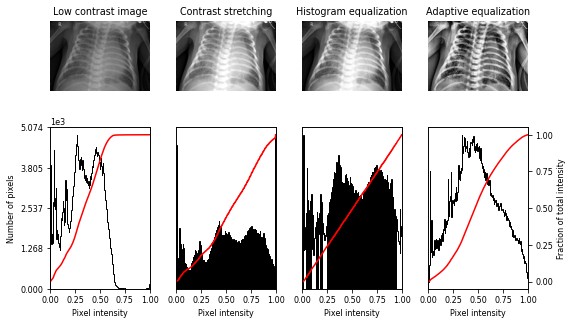

In [4]:
# Load an example image
path=train['ImagePath'][5]
img = mpimg.imread(path)
equalization(img)


# Data Transformation

https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/

In [ ]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html --user

## Adjust Image size

In [5]:
def adjustImageSize(imagePath, newWidth, newHeight):
    p = transforms.Compose([transforms.Scale((newWidth,newHeight))])
    img = Image.open(path)
    p(img).size
    return  p(img)

In [6]:
path="covid-chestxray-dataset-master/covid-chestxray-dataset-master/images/0a7faa2a.jpg"
adjustImageSize(path, 224, 224).size

(224, 224)

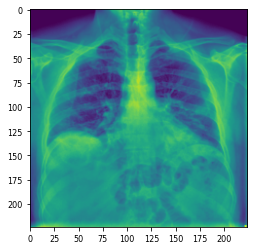

In [7]:
plt.imshow(adjustImageSize(df['ImagePath'][1], 224, 224))
plt.savefig("Statistics/adjustImageSize.pdf")
plt.savefig("Statistics/adjustImageSize.png")


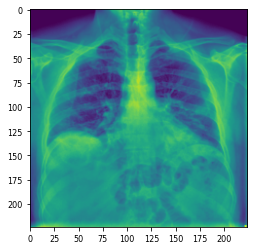

In [8]:
plt.imshow(adjustImageSize(train['ImagePath'][5], 224, 224))
plt.savefig("Statistics/adjustImageSize.pdf")
plt.savefig("Statistics/adjustImageSize.png")

## Data augmentation

In [9]:
def RotateImage(path, angle, mode='wrap'):
    img = mpimg.imread(path)
    rotated = rotate(img, angle=angle, mode = mode)
    io.imshow(rotated)
    plt.title('Rotate Image')
    return rotated

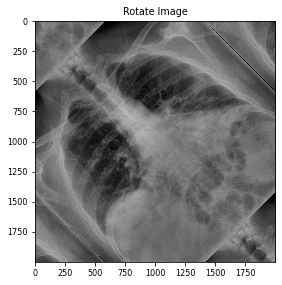

In [10]:
path="covid-chestxray-dataset-master/covid-chestxray-dataset-master/images/0a7faa2a.jpg"
io.imshow(RotateImage(path, 45, mode='wrap'))
plt.savefig("Statistics/RotateImage.pdf")
plt.savefig("Statistics/RotateImage.png")

In [11]:
def shiftedImage(path, translation=(25,25),mode='wrap'):
    img = mpimg.imread(path)
    transform = AffineTransform(translation=translation)
    wrapShift = warp(img,transform,mode=mode)
    plt.title('shifted Image')
    return wrapShift

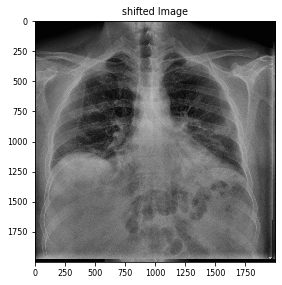

In [12]:
path="covid-chestxray-dataset-master/covid-chestxray-dataset-master/images/0a7faa2a.jpg"
io.imshow(shiftedImage(path, translation=(25,25),mode='wrap'))
plt.savefig("Statistics/shiftedImage.pdf")
plt.savefig("Statistics/shiftedImage.png")

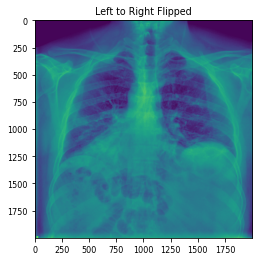

In [13]:
#flip image left-to-right
path="covid-chestxray-dataset-master/covid-chestxray-dataset-master/images/0a7faa2a.jpg"
image = mpimg.imread(path)
flipLR = np.fliplr(image)
plt.imshow(flipLR)
plt.title('Left to Right Flipped')
plt.savefig("Statistics/FlippedImage.pdf")
plt.savefig("Statistics/FlippedImage.png")

Text(0.5, 1.0, 'Up Down Flipped')

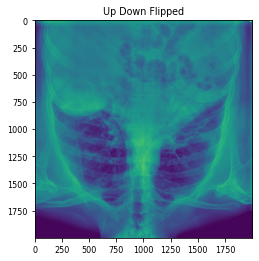

In [14]:
#flip image up-to-down
flipUD = np.flipud(image)
plt.imshow(flipUD)
plt.title('Up Down Flipped')

Text(0.5, 1.0, 'Random Noise')

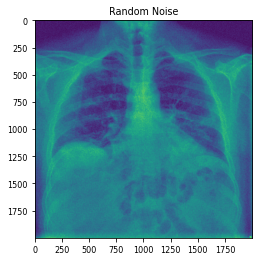

In [15]:
#standard deviation for noise to be added in the image
sigma=0.155
#add random noise to the image
noisyRandom = random_noise(image,var=sigma**2)
plt.imshow(noisyRandom)
plt.title('Random Noise')

Text(0.5, 1.0, 'Blurred Image')

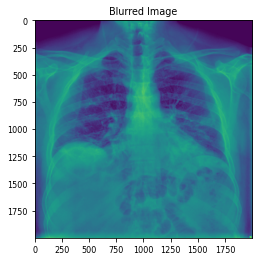

In [16]:
#blur the image
blurred = gaussian(image,sigma=1,multichannel=True)

plt.imshow(blurred)
plt.title('Blurred Image')

In [ ]:
!pip install tqdm -U

In [17]:
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
%matplotlib inline
sns.set_style('darkgrid')

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "data/"

In [19]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}

In [20]:
rps_dataset = datasets.ImageFolder(root = root_dir + "train",
                                   transform = image_transforms["train"]
                                  )
rps_dataset

Dataset ImageFolder
    Number of datapoints: 4389
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [21]:
rps_dataset[0]

(tensor([[[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],
 
         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],
 
         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922,